In [1]:
#Load needed python routines
from matplotlib import pyplot as plt
import xrayutilities as xu
from scipy import misc
import os
import numpy as np
import pandas as pd
import peakutils
from matplotlib import rcParams
from matplotlib import patches
import sys
#Load 4-id-c functions 
from s4idc_funcs_v2 import *

In [2]:
# bokeh packages
from bokeh.io import output_file,show,output_notebook,push_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper, Select, Slider
from bokeh.palettes import Category10
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel
output_notebook()

Loading BokehJS ...

In [3]:
#Set Fonts/Plot Style
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams.update({'font.size': 18})
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.major.size'] = 10
rcParams['ytick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True

In [4]:
#Choose data file
specpath = "./data/"
specfile = "SSFeb21_mca.mca"

# Get the spec file
sf = specFile(specpath+specfile)
#df = get_specScan(sf, 176)  #use file number

In [5]:
#function for field dependent for Pr and Er
def field_dep_XMCD(field, Erscan,Prscan):
    Erdata = []
    Prdata = []
    for i in range(len(field)):
        Erdata.append(XMCD(sf,Erscan[i]))
        Prdata.append(XMCD(sf,Prscan[i]))
    
    Erdata = np.array(Erdata)
    Prdata = np.array(Prdata)

    #selecting energy, TEYsum, TEYxmcd
    Er_energy = Erdata[:,0,:]
    Er_TEYsum = Erdata[:,3,:]
    Er_TEYxmcd = Erdata[:,4,:]
    
    Pr_energy = Prdata[:,0,:]
    Pr_TEYsum = Prdata[:,3,:]
    Pr_TEYxmcd = Prdata[:,4,:]
    
    #norm_xmcd
    ScEr_TEYsum = np.zeros(Er_TEYsum.shape);
    ScEr_TEYxmcd = np.zeros(Er_TEYsum.shape);
    for i in range(len(field)):
        ScEr_TEYsum[i,:], ScEr_TEYxmcd[i,:] = norm_xmcd(Er_TEYsum[i,:],Er_TEYxmcd[i,:]);
    
    ScPr_TEYsum = np.zeros(Pr_TEYsum.shape);
    ScPr_TEYxmcd = np.zeros(Pr_TEYsum.shape);
    for i in range(len(field)):
        ScPr_TEYsum[i,:], ScPr_TEYxmcd[i,:] = norm_xmcd(Pr_TEYsum[i,:],Pr_TEYxmcd[i,:]);
    
    #Correct XMCD zero
    for i in range(len(field)):
        ScEr_TEYxmcd[i,:] -=  np.average(ScEr_TEYxmcd[i,-5:-1]);
        ScPr_TEYxmcd[i,:] -=  np.average(ScPr_TEYxmcd[i,-5:-1]);

    #ploting
    col = ["red", "blue" , "green", 'yellow', 'orange', 'purple', 'cyan', 'white', 'gray', 'navy', 
           'pink', 'olive', 'orchid', 'sienna',"red", "blue" , "green", 'yellow', 'orange', 'purple', 
           'cyan', 'white', 'gray', 'navy', 'pink', 'olive', 'orchid', 'sienna']
    colors=[]
    for i in range(len(field)):
        colors.append(col[i])
        
    #Er_XAS 
    plt.style.use('dark_background')
    fig,ax = plt.subplots(2,2,figsize=(20,20))
    ax[0,0].set_ylabel('Norm XAS')
    ax[0,0].set_xlabel('Energy (eV)')
    ax[0,0].set_title('Er XAS', color='w')
    for i in range(len(field)):
        ax[0,0].plot(Er_energy[i,:],ScEr_TEYsum[i,:],linewidth=3,color=colors[i],label=str(field[i])+' T')
    ax[0,0].legend(loc=2)
    
    #Er XMCD
    ax[0,1].set_ylabel('Norm XMCD')
    ax[0,1].set_xlabel('Energy (eV)')
    for i in range(len(field)):
        ax[0,1].plot(Er_energy[i,:],ScEr_TEYxmcd[i,:],linewidth=3,color=colors[i],label=str(field[i])+' T')
    ax[0,1].legend(loc=0)
    ax[0,1].set_title('Er XMCD', color='w')
    

    #Pr_XAS
    ax[1,0].set_title('Pr_XAS',color='w')
    ax[1,0].set_ylabel('Norm XAS')
    ax[1,0].set_xlabel('Energy')
    for i in range(len(field)):
        ax[1,0].plot(Pr_energy[i,:],ScPr_TEYsum[i,:],linewidth=3, linestyle='-',color=colors[i],label=str(field[i])+' T')
    ax[1,0].legend()
    #Pr_XMCD

    ax[1,1].set_title('Pr_XMCD',color='w')
    ax[1,1].set_ylabel('Norm XMCD')
    ax[1,1].set_xlabel('Energy')
    for i in range(len(field)):
        ax[1,1].plot(Pr_energy[i,:],ScPr_TEYxmcd[i,:],linewidth=3, linestyle='-',color=colors[i],label=str(field[i])+' T')
    ax[1,1].legend(loc=1)
    
   #XMCD peak selection
    Pk_XMCD_Er = np.zeros(field.shape)
    Pk_XMCD_Pr = np.zeros(field.shape)

    for i in range(len(field)):
        if abs(np.nanmax(ScEr_TEYxmcd[i,:])) > abs(np.nanmin(ScEr_TEYxmcd[i,:])):
            Pk_XMCD_Er[i] = np.nanmax(ScEr_TEYxmcd[i,:])
        else:
            Pk_XMCD_Er[i] = np.nanmin(ScEr_TEYxmcd[i,:])               
    for i in range(len(field)):
        if abs(np.nanmin(ScPr_TEYxmcd[i,:]))>abs(np.nanmax(ScPr_TEYxmcd[i,:])):
            Pk_XMCD_Pr[i] = np.nanmin(ScPr_TEYxmcd[i,:]) 
        else:
            Pk_XMCD_Pr[i] = np.nanmax(ScPr_TEYxmcd[i,:]) 
    #XMCD_Peak Analysis      
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title('Peak_XMCD',color='w')
    ax.set_ylabel('XMCD_Peak')
    ax.set_xlabel('Field (T)')
    ax.plot(field,Pk_XMCD_Er,'bo', label='Er',markersize=12)
    ax.plot(field,Pk_XMCD_Pr,'mo',label='Pr',markersize=12)
    ax.axhline(0,color='w')
    ax.legend(frameon=False)
    #name=data10[1:4]
    #return plt.savefig(name)
    plt.show()

In [6]:
#field dependent measurement from 0-5 T for sample 4(100)
#field = np.append((0,0.1),np.arange(0.5,5.5,.5))  
#Erscan = np.arange(39,63,2)    #0.1 T 373
#Prscan= np.arange(40,64,2)  #M5 edge


#field dependent measurement from 0-5 T for sample 4(100) Pr M4 edge
field_100_M4 = np.array([0.1,1,2,3,4])  
Erscan_100_M5 = np.array([41,45,49,53,57])   #0.1 T 373
Prscan_100_M4 = np.arange(374,379,1)  #M4 edge

#field dependent meas from 5 T to 0T for sample 4 (100)
#field1 = np.arange(4.5,0.4,-.5)
#field2=np.array(0.1)
#field=np.append(field1,field2)
#Erscan = np.arange(63,83,2)
#Prscan = np.arange(64,84,2)

#field dependent meas (combined) from 0 to 5 T and 5 T to 0T for sample 4 (100)
#field0 = np.append((0,.1),np.arange(0.5,5.5,.5))
#field1 = np.arange(4.5,0.4,-.5)
#field2=np.array(0.1)
#field3=np.append(field1,field2)
#field_100=np.append(field0,field3)
#Erscan_100 = np.arange(39,83,2)
#Prscan_100 = np.arange(40,84,2)


#field dependent measurement from 0-5 T for sample 4(110)
#field =  np.arange(0,5,.5)  
#Erscan = np.arange(157,177,2)
#Prscan = np.arange(158,178,2)

#field dependent measurement from 0- (-5)T  for sample 4(110)
#field =  np.array([0,-1,-2,-2.5,-3,-4,-5])  
#Erscan = np.arange(237,251,2)
#Prscan = np.arange(238,252,2) 
 
#field dependent measurement from -5 -1T for sample 4(110)
#field =  np.array([-5, -4,-3,-2.5,-2,-1])  
#Erscan = np.arange(249,261,2)
#Prscan = np.arange(250,262,2)

#field dependent measurement from 0 to (-5)T and -5 to 0 T for sample 4(110)
field_110 =  np.array([0,-1,-2,-2.5,-3,-4,-5, -4, -3, -2.5, -2, -1])  
Erscan_110 = np.arange(237,261,2)
Prscan_110 = np.arange(238,262,2) 

#field dependent measurement from 0-5 for sample 4(111)
field_111 =  np.array([0.1,0.5,1,1.5,2,3,4,5])  
Erscan_111 = np.array([351,353,313,355,357,317,319,324])
Prscan_111 = np.array([352,354,314,356,318,358,320,325])

#field_dep_XMCD(field, Erscan,Prscan)
#field_dep_XMCD(field, Erscan,Prscan)

Normalization:  1.238972942563
Normalization:  1.641998367896
Normalization:  1.6517781726299998
Normalization:  1.7205950052640002
Normalization:  1.7779819270330002
Normalization:  0.21185057669989998
Normalization:  0.26272610769099997
Normalization:  0.268122117686
Normalization:  0.28458410085200003
Normalization:  0.27984103877


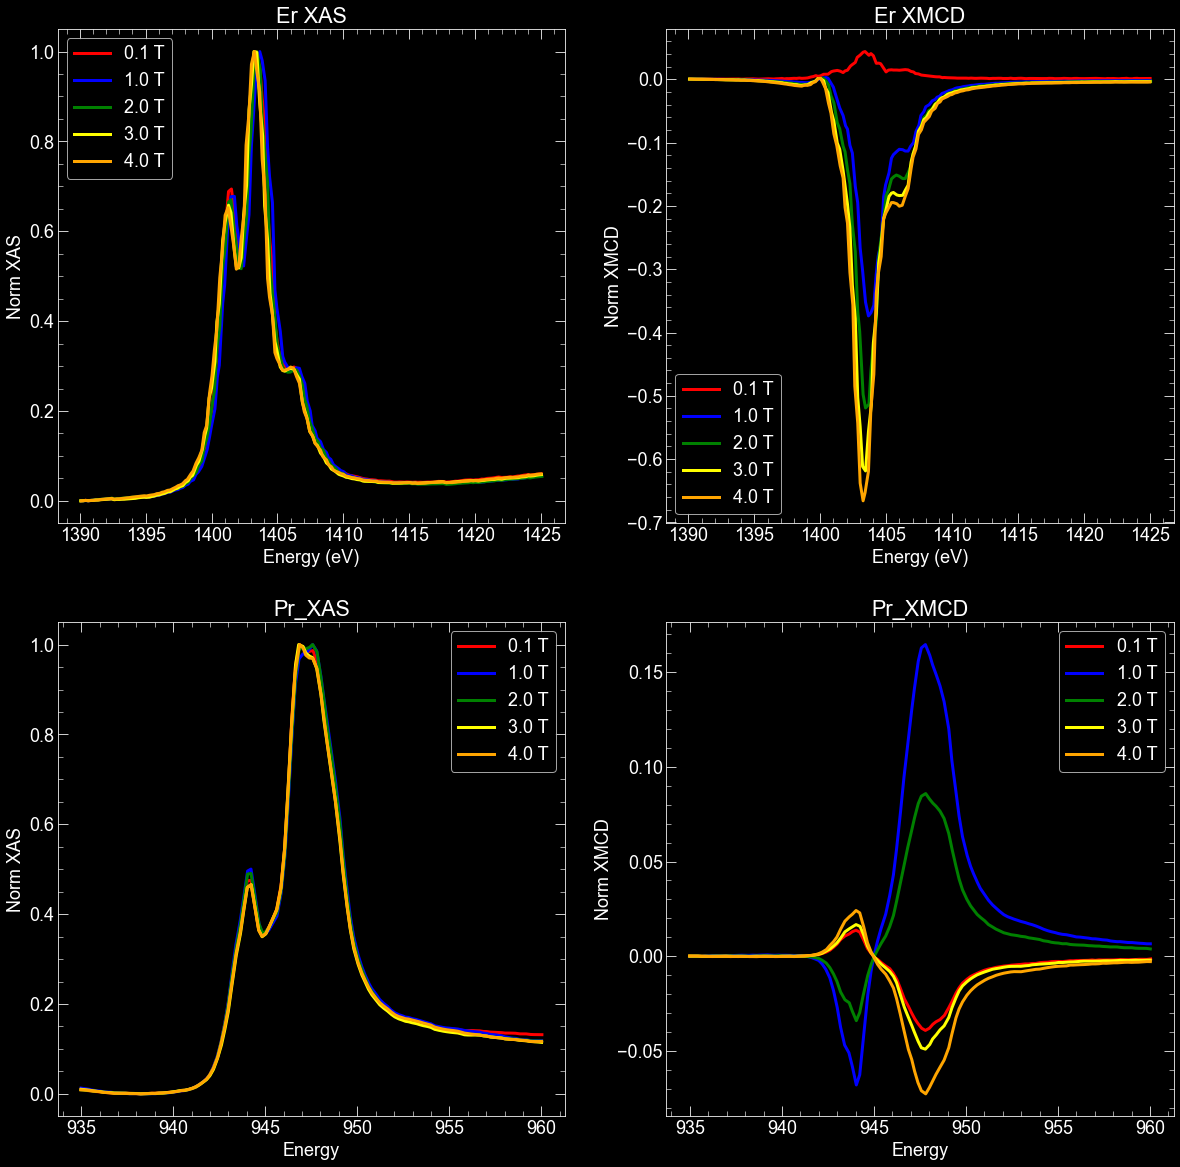

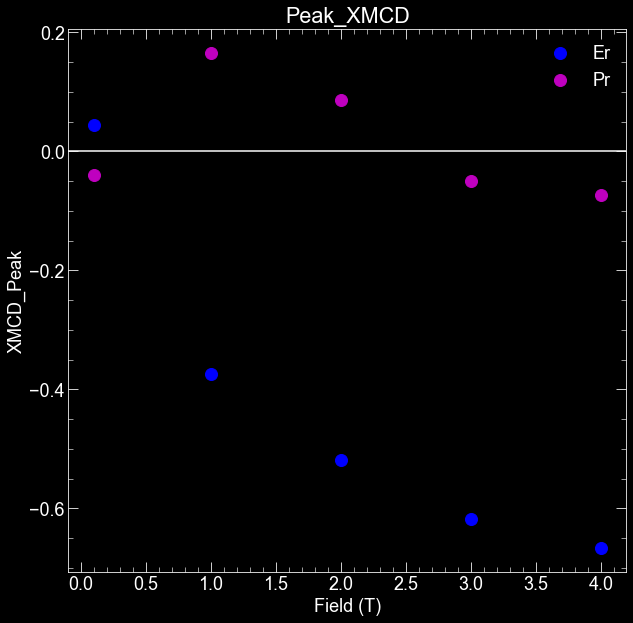

In [20]:
field_dep_XMCD(field_100_M4, Erscan_100_M5,Prscan_100_M4)
#field_dep_XMCD(field_110, Erscan_110,Prscan_110)
#field_dep_XMCD(field_111, Erscan_111,Prscan_111)

In [8]:
#function for temperature dependent for Pr and Er
def temp_dep_XMCD(temp, Erscan,Prscan):
    Erdata = []
    Prdata = []
    for i in range(len(temp)):
        Erdata.append(XMCD(sf,Erscan[i]))
        Prdata.append(XMCD(sf,Prscan[i]))
    
    Erdata = np.array(Erdata)
    Prdata = np.array(Prdata)
    
    #selecting energy, TEYsum, TEYxmcd
    Er_energy = Erdata[:,0,:]
    Er_TEYsum = Erdata[:,3,:]
    Er_TEYxmcd = Erdata[:,4,:]
    
    Pr_energy = Prdata[:,0,:]
    Pr_TEYsum = Prdata[:,3,:]
    Pr_TEYxmcd = Prdata[:,4,:]
    
    #normalizing
    ScEr_TEYsum = np.zeros(Er_TEYsum.shape);
    ScEr_TEYxmcd = np.zeros(Er_TEYsum.shape);
    for i in range(len(temp)):
        ScEr_TEYsum[i,:], ScEr_TEYxmcd[i,:] = norm_xmcd(Er_TEYsum[i,:],Er_TEYxmcd[i,:]);

    ScPr_TEYsum = np.zeros(Pr_TEYsum.shape);
    ScPr_TEYxmcd = np.zeros(Pr_TEYsum.shape);
    for i in range(len(temp)):
        ScPr_TEYsum[i,:], ScPr_TEYxmcd[i,:] = norm_xmcd(Pr_TEYsum[i,:],Pr_TEYxmcd[i,:]);
    
    #Correct XMCD zero
    for i in range(len(temp)):
        ScEr_TEYxmcd[i,:] -=  np.average(ScEr_TEYxmcd[i,-5:-1]);
        ScPr_TEYxmcd[i,:] -=  np.average(ScPr_TEYxmcd[i,-5:-1]);

    #ploting
    col = ["red", "blue" , "green", 'yellow', 'orange', 'purple', 'cyan', 'white', 'gray', 'navy', 
           'pink', 'olive', 'orchid', 'sienna',"red", "blue" , "green", 'yellow', 'orange', 'purple', 
           'cyan', 'white', 'gray', 'navy', 'pink', 'olive', 'orchid', 'sienna']
    colors=[]
    for i in range(len(temp)):
        colors.append(col[i])
        
       #Er_XAS 
    plt.style.use('dark_background')
    fig,ax = plt.subplots(2,2,figsize=(20,20))
    ax[0,0].set_ylabel('Norm XAS')
    ax[0,0].set_xlabel('Energy (eV)')
    ax[0,0].set_title('Er XAS', color='w')
    for i in range(len(temp)):
        ax[0,0].plot(Er_energy[i,:],ScEr_TEYsum[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
    ax[0,0].legend(loc=2)
    
    #Er XMCD
    ax[0,1].set_ylabel('Norm XMCD')
    ax[0,1].set_xlabel('Energy (eV)')
    for i in range(len(temp)):
        ax[0,1].plot(Er_energy[i,:],ScEr_TEYxmcd[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
    ax[0,1].legend(loc=0)
    ax[0,1].set_title('Er XMCD', color='w')
    

    #Pr_XAS
    ax[1,0].set_title('Pr_XAS',color='w')
    ax[1,0].set_ylabel('Norm XAS')
    ax[1,0].set_xlabel('Energy')
    for i in range(len(temp)):
        ax[1,0].plot(Pr_energy[i,:],ScPr_TEYsum[i,:],linewidth=3, linestyle='-',color=colors[i],label=str(temp[i])+' K')
    ax[1,0].legend()
    #Pr_XMCD

    ax[1,1].set_title('Pr_XMCD',color='w')
    ax[1,1].set_ylabel('Norm XMCD')
    ax[1,1].set_xlabel('Energy')
    for i in range(len(temp)):
        ax[1,1].plot(Pr_energy[i,:],ScPr_TEYxmcd[i,:],linewidth=3, linestyle='-',color=colors[i],label=str(temp[i])+' K')
    ax[1,1].legend()
    
    
   # XMCD height analysis
    Pk_XMCD_Er = np.zeros(temp.shape)
    Pk_XMCD_Pr = np.zeros(temp.shape)

    for i in range(len(temp)):
        if abs(np.nanmax(ScEr_TEYxmcd[i,:])) > abs(np.nanmin(ScEr_TEYxmcd[i,:])):
            Pk_XMCD_Er[i] = np.nanmax(ScEr_TEYxmcd[i,:])
        else:
            Pk_XMCD_Er[i] = np.nanmin(ScEr_TEYxmcd[i,:])               
    for i in range(len(temp)):
        if abs(np.nanmin(ScPr_TEYxmcd[i,:]))>abs(np.nanmax(ScPr_TEYxmcd[i,:])):
            Pk_XMCD_Pr[i] = np.nanmin(ScPr_TEYxmcd[i,:]) 
        else:
            Pk_XMCD_Pr[i] = np.nanmax(ScPr_TEYxmcd[i,:]) 
            
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title('XMCD Peak',color='w')
    ax.set_ylabel('XMCD_Peak')
    ax.set_xlabel('Temp (K)')
    ax.plot(temp,Pk_XMCD_Er,'bo', label='Er',markersize=12)
    ax.plot(temp,Pk_XMCD_Pr,'mo',label='Pr',markersize=12)
    ax.axhline(0,color='w')
    ax.legend(frameon=False)
    #name=data10[1:4]
    return plt.savefig('name')
    plt.show()

In [9]:
temp_100 = np.arange(7,33,3)   #(sample 4(100) H=2T)
Erscan_100 = np.arange(84,102,2)   
Prscan_100 = np.arange(85,103,2)


#temp= np.arange(7,35,3)   #sample 4(100) H=-2T
#Erscan = np.arange(128,148,2)
#Prscan = np.arange(129,149,2)

temp_100_5 = np.array([13,14,15,16,17,18,19,20,21,22,23,24,26,28])   #(sample 4(100) H=5T)
Erscan_100_5 = np.append(np.arange(266,284,2), np.arange(286,296,2))
Prscan_100_5 = np.append(np.arange(267,285,2), np.arange(287,297,2))

temp_110 = np.arange(7,33,3)   #(sample 4(110) H=2T)
Erscan_110 = np.arange(196,214,2)
Prscan_110 = np.arange(197,215,2)

temp_110_5 = np.array([14,16,17,18,19,21,23,25,27])   #(sample 4(110) H=5T)
Erscan_110_5 = np.arange(215,233,2)
Prscan_110_5 = np.arange(216,234,2)

temp_111 = np.array([7,10,13,16,19,22,24,25,26,28,31])   #(sample 4(111) H=2T)
Erscan_111 = np.append(np.arange(331,345,2), [347,363,365,367])
Prscan_111 = np.append(np.arange(332,346,2), [348,364,366,368])

#temp_dep_XMCD(temp, Erscan,Prscan)

Normalization:  1.7093420915140003
Normalization:  1.69234916903
Normalization:  1.719214183688
Normalization:  1.702956949282
Normalization:  1.7278483946610002
Normalization:  1.7345260507750002
Normalization:  1.7103066708180001
Normalization:  1.7137020260680003
Normalization:  1.6766357414270001
Normalization:  0.810901760304
Normalization:  0.821178576628
Normalization:  0.8289878150810001
Normalization:  0.8370815738470001
Normalization:  0.843245610385
Normalization:  0.85024764166
Normalization:  0.8538477607259999
Normalization:  0.8542694722770001
Normalization:  0.8591385745689999


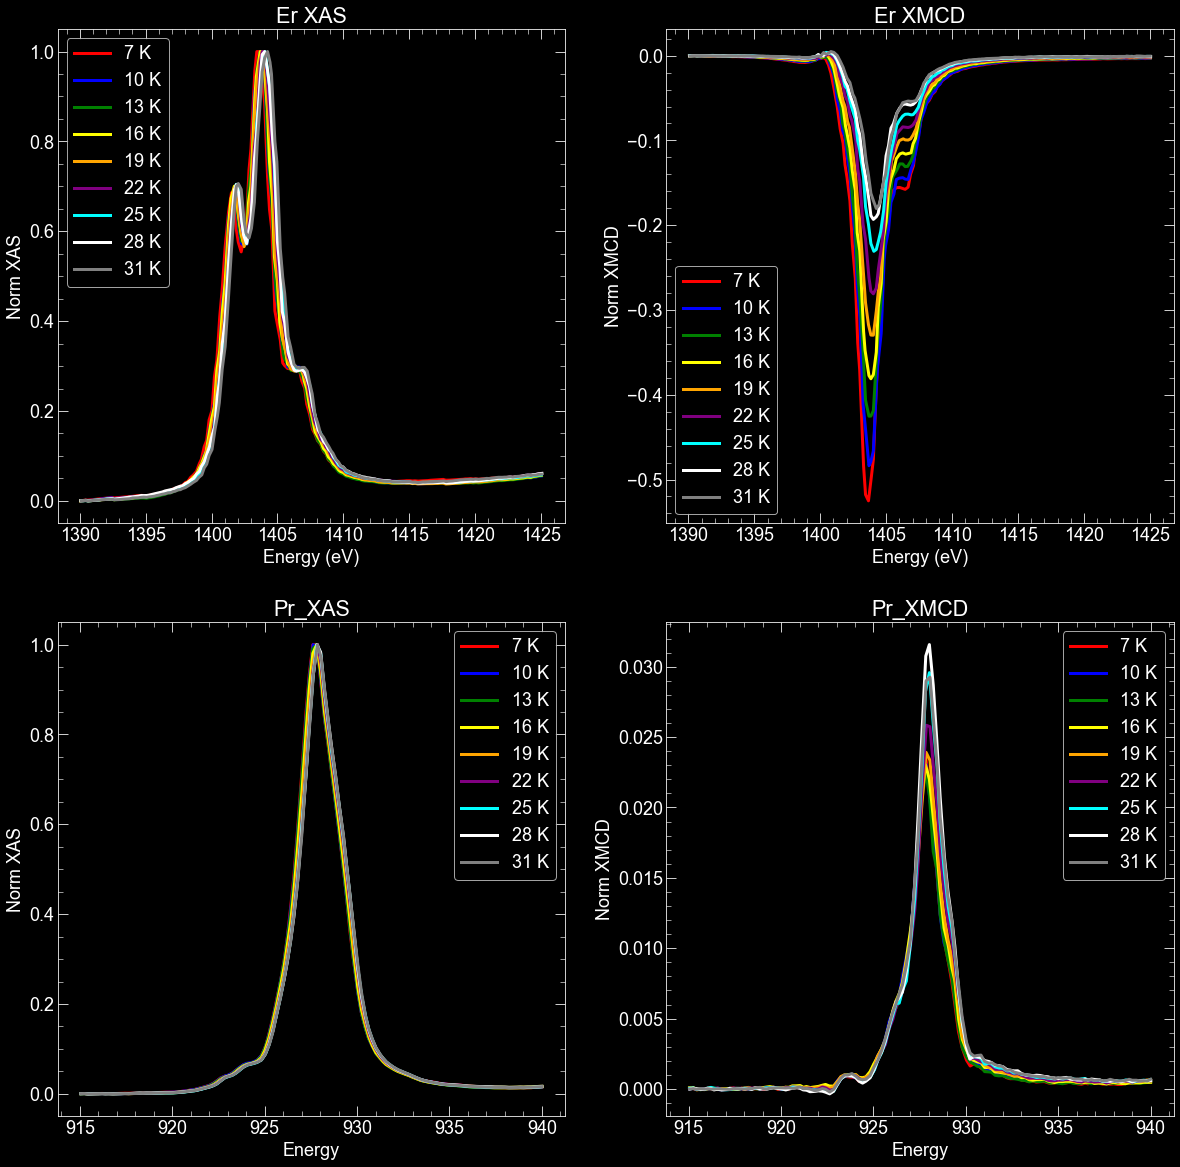

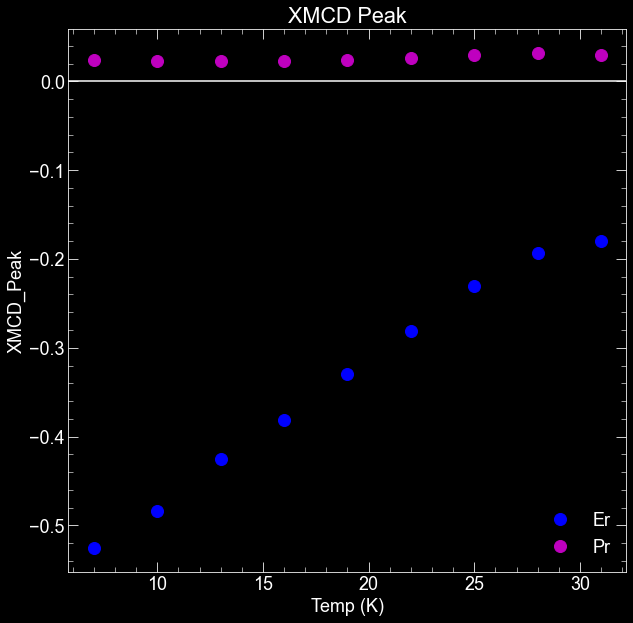

In [10]:
temp_dep_XMCD(temp_100, Erscan_100,Prscan_100)

In [11]:
#function for + - field dependent for Pr and Er
def field_dep_XMCD_diff(field, Erscan_pT, Erscan_nT, Prscan_pT, Prscan_nT ):
    Erdata_pT = []
    Erdata_nT = []

    Prdata_pT = []
    Prdata_nT = []

    for i in range(len(field)):
        Erdata_pT.append(XMCD(sf,Erscan_pT[i]))
        Erdata_nT.append(XMCD(sf,Erscan_nT[i]))
    
        Prdata_pT.append(XMCD(sf,Prscan_pT[i]))
        Prdata_nT.append(XMCD(sf,Prscan_nT[i]))
    
    Erdata_pT = np.array(Erdata_pT)
    Erdata_nT= np.array(Erdata_nT)

    Prdata_pT = np.array(Prdata_pT)
    Prdata_nT= np.array(Prdata_nT)
    
    #selecting energy, TEYsum, TEYxmcd
    energy_pT_Er = Erdata_pT[:,0,:]
    tey_sum_pT_Er = Erdata_pT[:,3,:]
    xmcd_tey_pT_Er = Erdata_pT[:,4,:]

    energy_pT_Pr = Prdata_pT[:,0,:]
    tey_sum_pT_Pr = Prdata_pT[:,3,:]
    xmcd_tey_pT_Pr = Prdata_pT[:,4,:]

    energy_nT_Er= Erdata_nT[:,0,:]
    tey_sum_nT_Er= Erdata_nT[:,3,:]
    xmcd_tey_nT_Er= Erdata_nT[:,4,:]

    energy_nT_Pr= Prdata_nT[:,0,:]
    tey_sum_nT_Pr= Prdata_nT[:,3,:]
    xmcd_tey_nT_Pr= Prdata_nT[:,4,:]
    
    #Fix energy shifts
    peak_pos_Er_pT= []
    peak_pos_Er_nT= []
    peak_pos_Pr_pT= []
    peak_pos_Pr_nT= []
    for i in range(len(field)):
        peak_Er_pT = np.where(tey_sum_pT_Er[i,:]==np.nanmax(tey_sum_pT_Er[i,:]))
        peak_Er_nT = np.where(tey_sum_nT_Er[i,:]==np.nanmax(tey_sum_nT_Er[i,:]))
        peak_Pr_pT = np.where(tey_sum_pT_Pr[i,:]==np.nanmax(tey_sum_pT_Pr[i,:]))
        peak_Pr_nT = np.where(tey_sum_nT_Pr[i,:]==np.nanmax(tey_sum_nT_Pr[i,:]))

        peak_pos_Er_pT.append(peak_Er_pT)
        peak_pos_Er_nT.append(peak_Er_nT)
        peak_pos_Pr_pT.append(peak_Pr_pT)
        peak_pos_Pr_nT.append(peak_Pr_nT)

    dif_Eng_Er= []
    dif_Eng_Pr= []
    for i in range(len(field)):     
        dif_Er = energy_pT_Er[i,:][peak_pos_Er_pT[i]] - energy_nT_Er[i,:][peak_pos_Er_nT[i]]
        dif_Pr = energy_pT_Pr[i,:][peak_pos_Pr_pT[i]] - energy_nT_Pr[i,:][peak_pos_Pr_nT[i]]
        dif_Eng_Er.append(dif_Er)
        dif_Eng_Pr.append(dif_Pr)

    for i in range(len(field)): 
        energy_nT_Er[i,:] += dif_Eng_Er[i]
        energy_nT_Pr[i,:] += dif_Eng_Pr[i]
        
    #norm_xmcd
    sctey_pT_Er= np.zeros(tey_sum_pT_Er.shape)
    scxmcd_tey_pT_Er= np.zeros(tey_sum_pT_Er.shape)

    sctey_pT_Pr= np.zeros(tey_sum_pT_Pr.shape)
    scxmcd_tey_pT_Pr= np.zeros(tey_sum_pT_Pr.shape)

    for i in range(len(field)):
        sctey_pT_Er[i,:], scxmcd_tey_pT_Er[i,:] = norm_xmcd(tey_sum_pT_Er[i,:], xmcd_tey_pT_Er[i,:])
        sctey_pT_Pr[i,:], scxmcd_tey_pT_Pr[i,:] = norm_xmcd(tey_sum_pT_Pr[i,:], xmcd_tey_pT_Pr[i,:])
    
    sctey_nT_Er = np.zeros(tey_sum_nT_Er.shape)
    scxmcd_tey_nT_Er = np.zeros(tey_sum_nT_Er.shape)

    sctey_nT_Pr = np.zeros(tey_sum_nT_Pr.shape)
    scxmcd_tey_nT_Pr = np.zeros(tey_sum_nT_Pr.shape)

    for i in range(len(field)):
        sctey_nT_Er[i,:], scxmcd_tey_nT_Er[i,:] = norm_xmcd(tey_sum_nT_Er[i,:], xmcd_tey_nT_Er[i,:])
        sctey_nT_Pr[i,:], scxmcd_tey_nT_Pr[i,:] = norm_xmcd(tey_sum_nT_Pr[i,:], xmcd_tey_nT_Pr[i,:])
    
    #Correct XMCD zero
    for i in range(len(field)):
        scxmcd_tey_pT_Er[i,:] -=  np.average(scxmcd_tey_pT_Er[i,-5:-1])
        scxmcd_tey_nT_Er[i,:] -=  np.average(scxmcd_tey_nT_Er[i,-5:-1])
    
        scxmcd_tey_pT_Pr[i,:] -=  np.average(scxmcd_tey_pT_Pr[i,-5:-1])
        scxmcd_tey_nT_Pr[i,:] -=  np.average(scxmcd_tey_nT_Pr[i,-5:-1])
    
    #Plotting
    col = ["red", "blue" , "green", 'yellow', 'orange', 'purple', 'cyan', 'white', 
           'gray', 'navy', 'pink', 'olive', 'orchid', 'sienna']
    colors=[]
    for i in range(len(field)):
        colors.append(col[i])
        
    #Look at backgrounds and subtracted data Er
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    for i in range(len(field)):
        ax1.plot(energy_pT_Er[i,:],sctey_pT_Er[i,:],linewidth=3, color=colors[i],label=str(field[i])+' T')
        ax1.plot(energy_nT_Er[i,:],sctey_nT_Er[i,:],linewidth=3, linestyle='--', color=colors[i],label='-'+str(field[i])+' T')
    ax1.legend()
    ax1.set_title('XAS_Er')

    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    for i in range(len(field)):
        ax2.plot(energy_pT_Er[i,:],scxmcd_tey_pT_Er[i,:],linewidth=3,color=colors[i],label=str(field[i])+' T')
        ax2.plot(energy_nT_Er[i,:],scxmcd_tey_nT_Er[i,:],linewidth=3,color=colors[i],linestyle='--',label='-'+str(field[i])+' T')
    ax2.legend()
    ax2.set_title('XMCD_Er')
     
    # subtracted data Pr
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    for i in range(len(field)):
        ax1.plot(energy_pT_Pr[i,:],sctey_pT_Pr[i,:],linewidth=3, color=colors[i],label=str(field[i])+' T')
        ax1.plot(energy_nT_Pr[i,:],sctey_nT_Pr[i,:],linewidth=3, linestyle='--', color=colors[i],label='-'+str(field[i])+' T')
    ax1.axhline(0,color='w')
    ax1.legend()
    ax1.set_title('XAS_Pr')


    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    for i in range(len(field)):
        ax2.plot(energy_pT_Pr[i,:],scxmcd_tey_pT_Pr[i,:],color=colors[i],linewidth=3,label=str(field[i])+' T')
        ax2.plot(energy_nT_Pr[i,:],scxmcd_tey_nT_Pr[i,:],color=colors[i],linewidth=3,linestyle='--',label='-'+str(field[i])+' T')
    ax2.legend(loc=2)
    ax2.set_title('XMCD_Pr')
    
    #XAS, XMCD +ve and _ve diff calculation
    sctey_sum_Er= np.zeros(sctey_pT_Er.shape)
    scxmcd_tey_dif_Er= np.zeros(scxmcd_tey_pT_Er.shape)

    sctey_sum_Pr= np.zeros(sctey_pT_Pr.shape)
    scxmcd_tey_dif_Pr= np.zeros(scxmcd_tey_pT_Pr.shape)

    for i in range(len(field)):
        sctey_sum_Er[i,:]=(sctey_pT_Er[i,:]+np.interp(energy_pT_Er[i,:],energy_nT_Er[i,:],sctey_nT_Er[i,:]))/2
        #sctey_sum_Er[i,:]=(sctey_pT_Er[i,:]+sctey_nT_Er[i,:])/2
        scxmcd_tey_dif_Er[i,:] = (scxmcd_tey_pT_Er[i,:] - np.interp(energy_pT_Er[i,:],energy_nT_Er[i,:],scxmcd_tey_nT_Er[i,:]))/2
        #scxmcd_tey_dif_Er[i,:] = (scxmcd_tey_pT_Er[i,:] + scxmcd_tey_nT_Er[i,:])/2
        
        sctey_sum_Pr[i,:]=(sctey_pT_Pr[i,:]-np.interp(energy_pT_Pr[i,:],energy_nT_Pr[i,:],sctey_nT_Pr[i,:]))/2
        #scxmcd_tey_dif_Pr[i,:] = (scxmcd_tey_pT_Pr[i,:] + np.interp(energy_pT_Pr[i,:],energy_nT_Pr[i,:],scxmcd_tey_nT_Pr[i,:]))/2
        scxmcd_tey_dif_Pr[i,:] = (scxmcd_tey_pT_Pr[i,:] + scxmcd_tey_nT_Pr[i,:])/2
    #scxmcd_tey_dif +=.0003
    
    #XAS +ve and _ve diff
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('XMCD_diff')
    ax1.set_xlabel('Energy (eV)')
    ax1.axhline(0,color='k')
    for i in range(len(field)):
        ax1.plot(energy_pT_Er[i,:],scxmcd_tey_dif_Er[i,:],color=colors[i],linewidth=3,label=str(field[i])+' T')
    ax1.legend()
    ax1.set_title('XMCD_diff_Er')

    #XMCD +ve and _ve diff
    ax2.set_ylabel('XMCD_diff')
    ax2.set_xlabel('Energy (eV)')
    ax2.axhline(0,color='k')
    for i in range(len(field)):
        ax2.plot(energy_pT_Pr[i,:],scxmcd_tey_dif_Pr[i,:],color=colors[i],linewidth=3,label=str(field[i])+' T')
    ax2.legend()
    ax2.set_title('XMCD_diff_Pr')
    
    #XMCD peak analysis
    Pk_scxmcd_dif_Er= np.zeros(field.shape)
    Pk_scxmcd_dif_Pr= np.zeros(field.shape)

    for i in range(len(field)):
        if abs(np.nanmax(scxmcd_tey_dif_Er[i,:])) >  abs(np.nanmin(scxmcd_tey_dif_Er[i,:])):
            Pk_scxmcd_dif_Er[i] = np.nanmax(scxmcd_tey_dif_Er[i,:])
        else:
            Pk_scxmcd_dif_Er[i] = np.nanmin(scxmcd_tey_dif_Er[i,:])
                 
    for i in range(len(field)):
        if abs(np.nanmax(scxmcd_tey_dif_Pr[i,:]))>abs(np.nanmin(scxmcd_tey_dif_Pr[i,:])):             
            Pk_scxmcd_dif_Pr[i] = np.nanmax(scxmcd_tey_dif_Pr[i,:])
        else:
            Pk_scxmcd_dif_Pr[i] = np.nanmin(scxmcd_tey_dif_Pr[i,:])
    #ploating peak       
    fig, ax1 = plt.subplots( figsize=(10,10))
    ax1.set_ylabel('diff_XMCD Peak')
    ax1.set_xlabel('Field (T)')
    ax1.plot(field,Pk_scxmcd_dif_Er, 'bo', label='Diff_Er_M5', markersize=15);
    ax1.plot(field,Pk_scxmcd_dif_Pr, 'mo', label='Diff_Pr_M5', markersize=15);
    ax1.axhline(0,color='w')
    ax1.legend(frameon=False)
    ax1.set_title('XMCD_diff_peak')
    plt.show()

In [12]:
#field dependent measurement for 2, 0.1 T for binary alloys
field_PrEr =  np.array([0.1,2])  
Erscan_pT_ErPr = np.array([382,384])  
Erscan_nT_ErPr = np.array([385,386])  
Prscan_pT_ErPr = np.array([394,399])  
Prscan_nT_ErPr = np.array([400,401])


#field dependent measurement for 5, 1, and 0.5 for sample 4(100)
field_100 =  np.array([5,1,0.5])  
Erscan_pT_100 = np.arange(114,120,2)
Erscan_nT_100 = np.arange(120,126,2)

Prscan_pT_100 = np.arange(115,120,2)
Prscan_nT_100 = np.arange(121,127,2)

#field dependent measurement from 0 to 5 T and 0 to -5 T for sample 4(110)
field_110 =  np.array([0,1,2,2.5,3,4]) 
Erscan_pT_110 = np.array([157,161,165,167,169,173]) 
Erscan_nT_110 = np.arange(237,249,2)
Prscan_pT_110 = np.array([158,162,166,168,170,174]) 
Prscan_nT_110 = np.arange(238,250,2)


#field_dep_XMCD_diff(field, Erscan_pT, Erscan_nT, Prscan_pT, Prscan_nT )

Normalization:  1.8112911429379999
Normalization:  0.705596942441
Normalization:  1.7205933004660001
Normalization:  0.612555079941
Normalization:  1.2230089199249998
Normalization:  0.492231027803
Normalization:  1.59700645659
Normalization:  0.619649942486
Normalization:  1.287037327475
Normalization:  0.5530113251700001
Normalization:  1.3141894722249998
Normalization:  0.559952409605


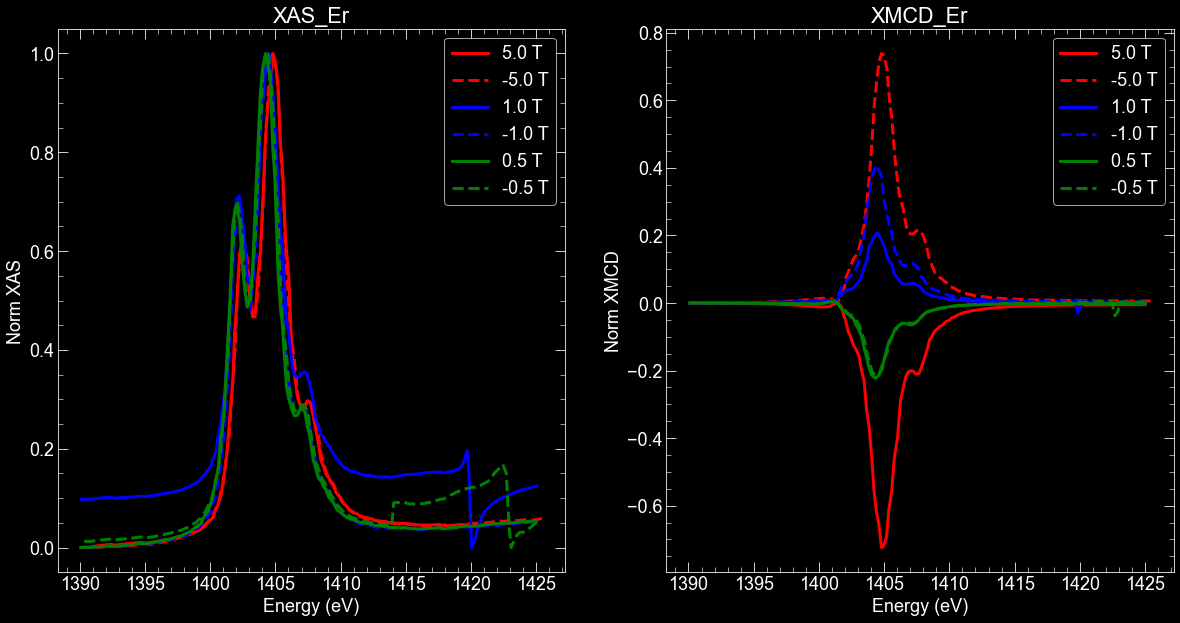

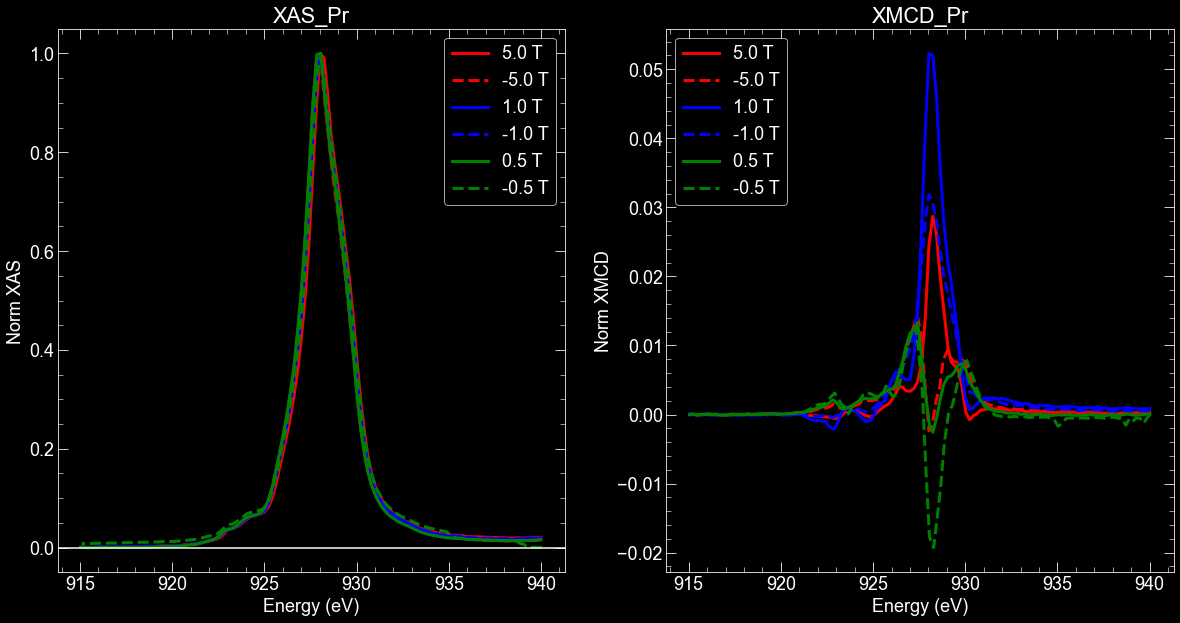

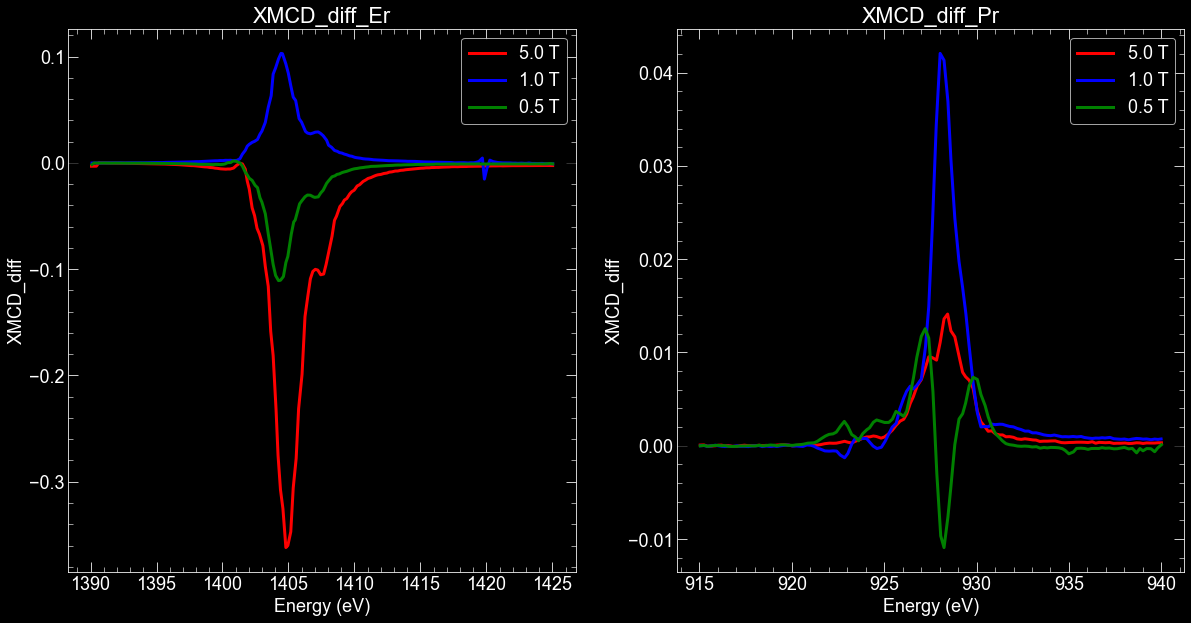

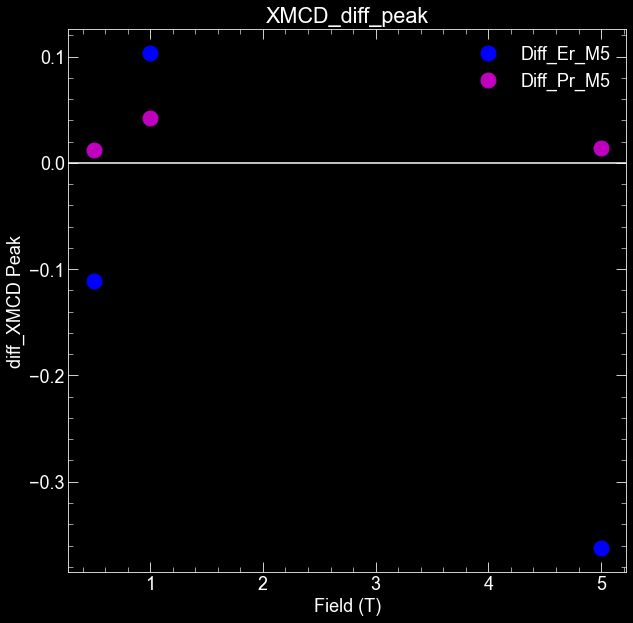

In [16]:
#field_dep_XMCD_diff(field_PrEr, Erscan_pT_ErPr, Erscan_nT_ErPr, Prscan_pT_ErPr, Prscan_nT_ErPr )
field_dep_XMCD_diff(field_100, Erscan_pT_100, Erscan_nT_100, Prscan_pT_100, Prscan_nT_100 )
#field_dep_XMCD_diff(field_110, Erscan_pT_110, Erscan_nT_110, Prscan_pT_110, Prscan_nT_110 )

In [45]:
#function for + - temp dependent for Pr and Er
def temp_dep_XMCD_diff(temp, Erscan_pT, Erscan_nT, Prscan_pT, Prscan_nT ):
    Erdata_pT = []
    Erdata_nT = []

    Prdata_pT = []
    Prdata_nT = []

    for i in range(len(temp)):
        Erdata_pT.append(XMCD(sf,Erscan_pT[i]))
        Erdata_nT.append(XMCD(sf,Erscan_nT[i]))
    
        Prdata_pT.append(XMCD(sf,Prscan_pT[i]))
        Prdata_nT.append(XMCD(sf,Prscan_nT[i]))
    
    Erdata_pT = np.array(Erdata_pT)
    Erdata_nT= np.array(Erdata_nT)

    Prdata_pT = np.array(Prdata_pT)
    Prdata_nT= np.array(Prdata_nT)

    energy_pT_Er = Erdata_pT[:,0,:]
    tey_sum_pT_Er = Erdata_pT[:,3,:]
    xmcd_tey_pT_Er = Erdata_pT[:,4,:]

    energy_pT_Pr = Prdata_pT[:,0,:]
    tey_sum_pT_Pr = Prdata_pT[:,3,:]
    xmcd_tey_pT_Pr = Prdata_pT[:,4,:]

    energy_nT_Er= Erdata_nT[:,0,:]
    tey_sum_nT_Er= Erdata_nT[:,3,:]
    xmcd_tey_nT_Er= Erdata_nT[:,4,:]

    energy_nT_Pr= Prdata_nT[:,0,:]
    tey_sum_nT_Pr= Prdata_nT[:,3,:]
    xmcd_tey_nT_Pr= Prdata_nT[:,4,:]
    
    sctey_pT_Er= np.zeros(tey_sum_pT_Er.shape)
    scxmcd_tey_pT_Er= np.zeros(tey_sum_pT_Er.shape)

    sctey_pT_Pr= np.zeros(tey_sum_pT_Pr.shape)
    scxmcd_tey_pT_Pr= np.zeros(tey_sum_pT_Pr.shape)
    

    #Fix energy shifts
    peak_pos_Er_pT= []
    peak_pos_Er_nT= []
    peak_pos_Pr_pT= []
    peak_pos_Pr_nT= []
    for i in range(len(temp)):
        peak_Er_pT = np.where(tey_sum_pT_Er[i,:]==np.nanmax(tey_sum_pT_Er[i,:]))
        peak_Er_nT = np.where(tey_sum_nT_Er[i,:]==np.nanmax(tey_sum_nT_Er[i,:]))
        peak_Pr_pT = np.where(tey_sum_pT_Pr[i,:]==np.nanmax(tey_sum_pT_Pr[i,:]))
        peak_Pr_nT = np.where(tey_sum_nT_Pr[i,:]==np.nanmax(tey_sum_nT_Pr[i,:]))

        peak_pos_Er_pT.append(peak_Er_pT)
        peak_pos_Er_nT.append(peak_Er_nT)
        peak_pos_Pr_pT.append(peak_Pr_pT)
        peak_pos_Pr_nT.append(peak_Pr_nT)

    dif_Eng_Er= []
    dif_Eng_Pr= []
    for i in range(len(temp)):     
        dif_Er = energy_pT_Er[i,:][peak_pos_Er_pT[i]] - energy_nT_Er[i,:][peak_pos_Er_nT[i]]
        dif_Pr = energy_pT_Pr[i,:][peak_pos_Pr_pT[i]] - energy_nT_Pr[i,:][peak_pos_Pr_nT[i]]
        dif_Eng_Er.append(dif_Er)
        dif_Eng_Pr.append(dif_Pr)

    for i in range(len(temp)): 
        energy_nT_Er[i,:] += dif_Eng_Er[i]
        energy_nT_Pr[i,:] += dif_Eng_Pr[i]

        
    #norm XMCD   
    for i in range(len(temp)):
        sctey_pT_Er[i,:], scxmcd_tey_pT_Er[i,:] = norm_xmcd(tey_sum_pT_Er[i,:], xmcd_tey_pT_Er[i,:])
        sctey_pT_Pr[i,:], scxmcd_tey_pT_Pr[i,:] = norm_xmcd(tey_sum_pT_Pr[i,:], xmcd_tey_pT_Pr[i,:])
    
    
    sctey_nT_Er = np.zeros(tey_sum_nT_Er.shape)
    scxmcd_tey_nT_Er = np.zeros(tey_sum_nT_Er.shape)

    sctey_nT_Pr = np.zeros(tey_sum_nT_Pr.shape)
    scxmcd_tey_nT_Pr = np.zeros(tey_sum_nT_Pr.shape)

    for i in range(len(temp)):
        sctey_nT_Er[i,:], scxmcd_tey_nT_Er[i,:] = norm_xmcd(tey_sum_nT_Er[i,:], xmcd_tey_nT_Er[i,:])
        sctey_nT_Pr[i,:], scxmcd_tey_nT_Pr[i,:] = norm_xmcd(tey_sum_nT_Pr[i,:], xmcd_tey_nT_Pr[i,:])
    
    #Correct XMCD zero
    for i in range(len(temp)):
        scxmcd_tey_pT_Er[i,:] -=  np.average(scxmcd_tey_pT_Er[i,-5:-1])
        scxmcd_tey_nT_Er[i,:] -=  np.average(scxmcd_tey_nT_Er[i,-5:-1])
    
        scxmcd_tey_pT_Pr[i,:] -=  np.average(scxmcd_tey_pT_Pr[i,-5:-1])
        scxmcd_tey_nT_Pr[i,:] -=  np.average(scxmcd_tey_nT_Pr[i,-5:-1])
    
    col = ["red", "blue" , "green", 'yellow', 'orange', 'purple', 'cyan', 'white', 
           'gray', 'navy', 'pink', 'olive', 'orchid', 'sienna']
    colors=[]
    for i in range(len(temp)):
        colors.append(col[i])
    
    #ErXAS
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    for i in range(len(temp)):
        ax1.plot(energy_pT_Er[i,:],sctey_pT_Er[i,:],linewidth=3, color=colors[i],label=str(temp[i])+' K')
        ax1.plot(energy_nT_Er[i,:],sctey_nT_Er[i,:],linewidth=3, linestyle='--', color=colors[i],label='-'+str(temp[i])+' K')
    ax1.legend()
    ax1.set_title('XAS_Er')

    #Er XMCD
    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    for i in range(len(temp)):
        ax2.plot(energy_pT_Er[i,:],scxmcd_tey_pT_Er[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
        ax2.plot(energy_nT_Er[i,:],scxmcd_tey_nT_Er[i,:],linewidth=3,color=colors[i],linestyle='--',label='-'+str(temp[i])+' K')
    ax2.legend()
    ax2.set_title('XMCD_Er')
     
    #  Pr XAS
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    for i in range(len(temp)):
        ax1.plot(energy_pT_Pr[i,:],sctey_pT_Pr[i,:],linewidth=3, color=colors[i],label=str(temp[i])+' K')
        ax1.plot(energy_nT_Pr[i,:],sctey_nT_Pr[i,:],linewidth=3, linestyle='--', color=colors[i],label='-'+str(temp[i])+' K')
    ax1.axhline(0,color='w')
    ax1.legend()
    ax1.set_title('XAS_Pr')

    #PrXMCD
    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    for i in range(len(temp)):
        ax2.plot(energy_pT_Pr[i,:],scxmcd_tey_pT_Pr[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
        ax2.plot(energy_nT_Pr[i,:],scxmcd_tey_nT_Pr[i,:],linewidth=3,color=colors[i],linestyle='--',label='-'+str(temp[i])+' K')
    ax2.legend(loc=2)
    ax2.set_title('XMCD_Pr')
    
    #XAS, XMCD +ve and _ve diff
    sctey_sum_Er= np.zeros(sctey_pT_Er.shape)
    scxmcd_tey_dif_Er= np.zeros(scxmcd_tey_pT_Er.shape)

    sctey_sum_Pr= np.zeros(sctey_pT_Pr.shape)
    scxmcd_tey_dif_Pr= np.zeros(scxmcd_tey_pT_Pr.shape)

    for i in range(len(temp)):
        sctey_sum_Er[i,:]=(sctey_pT_Er[i,:]+np.interp(energy_pT_Er[i,:],energy_nT_Er[i,:],sctey_nT_Er[i,:]))/2
        scxmcd_tey_dif_Er[i,:] = (scxmcd_tey_pT_Er[i,:] - np.interp(energy_pT_Er[i,:],energy_nT_Er[i,:],scxmcd_tey_nT_Er[i,:]))/2
        sctey_sum_Pr[i,:]=(sctey_pT_Pr[i,:]+np.interp(energy_pT_Pr[i,:],energy_nT_Pr[i,:],sctey_nT_Pr[i,:]))/2
        scxmcd_tey_dif_Pr[i,:] = (scxmcd_tey_pT_Pr[i,:] - np.interp(energy_pT_Pr[i,:],energy_nT_Pr[i,:],scxmcd_tey_nT_Pr[i,:]))/2
    #scxmcd_tey_dif +=.0003
    
    #XAS +ve and -ve diff
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('XMCD_diff')
    ax1.set_xlabel('Energy (eV)')
    ax1.axhline(0,color='k')
    for i in range(len(temp)):
        ax1.plot(energy_pT_Er[i,:],scxmcd_tey_dif_Er[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
    ax1.legend()
    ax1.set_title('XMCD_diff_Er')

    #XMCD +ve and -ve diff
    ax2.set_ylabel('XMCD_diff')
    ax2.set_xlabel('Energy (eV)')
    ax2.axhline(0,color='k')
    for i in range(len(temp)):
        ax2.plot(energy_pT_Pr[i,:],scxmcd_tey_dif_Pr[i,:],linewidth=3,color=colors[i],label=str(temp[i])+' K')
    ax2.legend()
    ax2.set_title('XMCD_diff_Pr')
    
    #Simple XMCD height analysis
    Pk_scxmcd_dif_Er= np.zeros(temp.shape)
    Pk_scxmcd_dif_Pr= np.zeros(temp.shape)

    for i in range(len(temp)):
        if abs(np.nanmax(scxmcd_tey_dif_Er[i,:])) >  abs(np.nanmin(scxmcd_tey_dif_Er[i,:])):
            Pk_scxmcd_dif_Er[i] = np.nanmax(scxmcd_tey_dif_Er[i,:])
        else:
            Pk_scxmcd_dif_Er[i] = np.nanmin(scxmcd_tey_dif_Er[i,:])
                 
    for i in range(len(temp)):
        if abs(np.nanmax(scxmcd_tey_dif_Pr[i,:]))>abs(np.nanmin(scxmcd_tey_dif_Pr[i,:])):             
            Pk_scxmcd_dif_Pr[i] = np.nanmax(scxmcd_tey_dif_Pr[i,:])
        else:
            Pk_scxmcd_dif_Pr[i] = np.nanmin(scxmcd_tey_dif_Pr[i,:])
            
    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.set_ylabel('diff_XMCD Peak')
    ax1.set_xlabel('Field (T)')
    ax1.plot(temp,Pk_scxmcd_dif_Er, 'bo', label='Diff_Er_M5', markersize=15);
    ax1.plot(temp,Pk_scxmcd_dif_Pr, 'mo', label='Diff_Pr_M5', markersize=15);
    ax1.axhline(0,color='w')
    ax1.legend(frameon=False)
    ax1.set_title('XMCD_diff_peak')
    plt.show()

Normalization:  1.7093420915140003
Normalization:  0.810901760304
Normalization:  1.69234916903
Normalization:  0.821178576628
Normalization:  1.719214183688
Normalization:  0.8289878150810001
Normalization:  1.702956949282
Normalization:  0.8370815738470001
Normalization:  1.7278483946610002
Normalization:  0.843245610385
Normalization:  1.7345260507750002
Normalization:  0.85024764166
Normalization:  1.7103066708180001
Normalization:  0.8538477607259999
Normalization:  1.7137020260680003
Normalization:  0.8542694722770001
Normalization:  1.6766357414270001
Normalization:  0.8591385745689999
Normalization:  1.454218123268
Normalization:  0.6183735884830001
Normalization:  1.408071946388
Normalization:  0.608158989059
Normalization:  1.270282540942
Normalization:  0.5814402954750001
Normalization:  1.221223297215
Normalization:  0.5739494148169999
Normalization:  1.1822862392250002
Normalization:  0.565994188195
Normalization:  1.155867864934
Normalization:  0.566608328706
Normalizatio

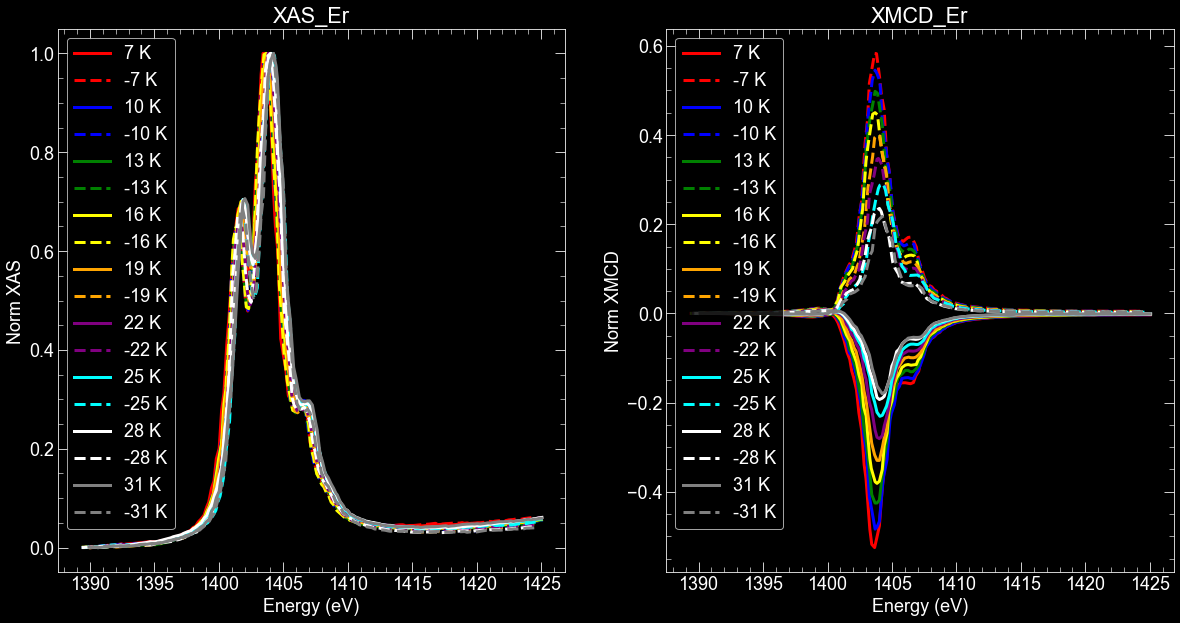

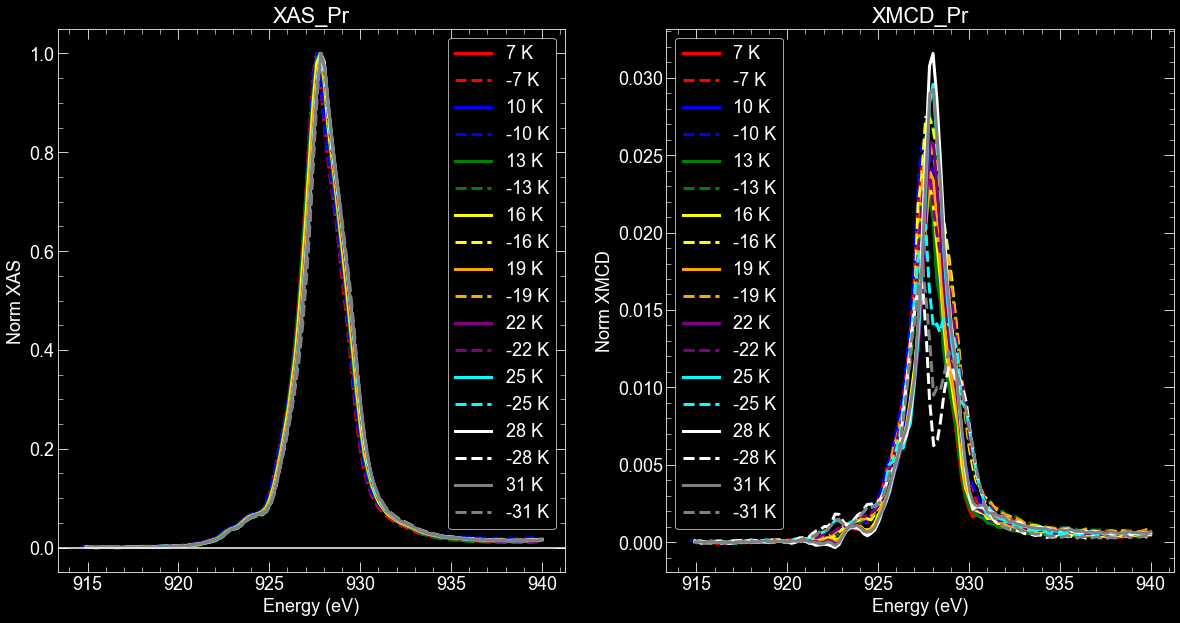

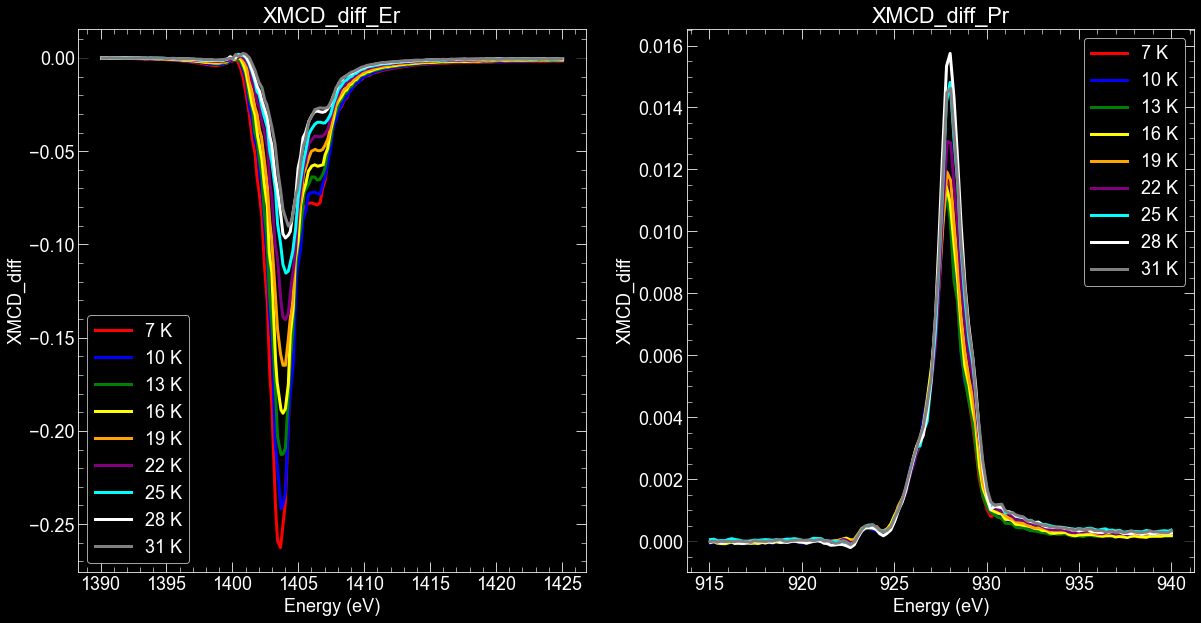

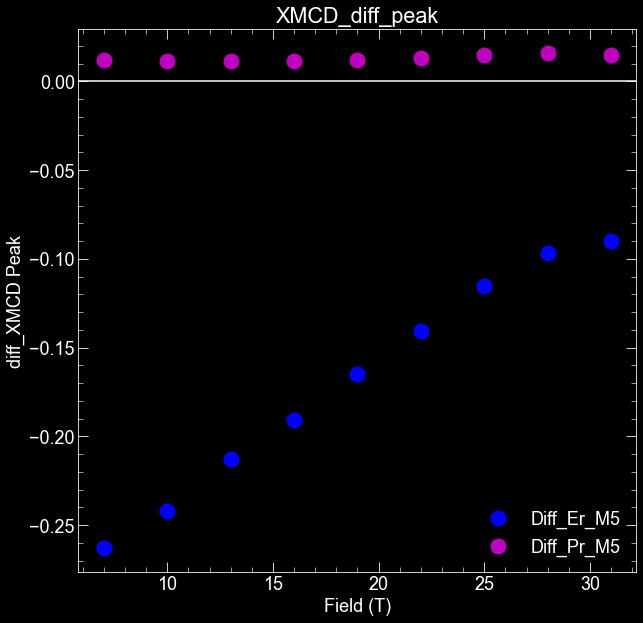

In [46]:
temp_100 = np.arange(7,33,3)   #(sample 4(100) H=2T) 
Erscan_pT_100 = np.arange(84,102,2)   
Prscan_pT_100 = np.arange(85,103,2)

#temp= np.arange(7,33,3)   #sample 4(100) H=-2T
Erscan_nT_100 = np.arange(128,146,2)
Prscan_nT_100 = np.arange(129,147,2)

temp_dep_XMCD_diff(temp_100, Erscan_pT_100, Erscan_nT_100, Prscan_pT_100, Prscan_nT_100 )

In [47]:
def ErPr_XMCD_diff( Erscan_pT, Erscan_nT, Prscan_pT, Prscan_nT ):
    energy_p5T_Er, _, _, tey_sum_p5T_Er, xmcd_tey_p5T_Er, tfy_sum_p5T_Er, xmcd_tfy_p5T_Er,_ = XMCD(sf,Erscan_pT)  
    energy_n5T_Er, _, _, tey_sum_n5T_Er, xmcd_tey_n5T_Er, tfy_sum_n5T_Er, xmcd_tfy_n5T_Er,_ = XMCD(sf,Erscan_nT)
    #energy_n5T_Er-=.15

    #reverse order of points
    energy_p5T_Er = energy_p5T_Er[::-1]
    energy_n5T_Er = energy_n5T_Er[::-1]
    tey_sum_p5T_Er = tey_sum_p5T_Er[::-1]
    tey_sum_n5T_Er = tey_sum_n5T_Er[::-1]
    xmcd_tey_p5T_Er = xmcd_tey_p5T_Er[::-1]
    xmcd_tey_n5T_Er = xmcd_tey_n5T_Er[::-1]


    energy_p5T_Pr, _, _, tey_sum_p5T_Pr, xmcd_tey_p5T_Pr, tfy_sum_p5T_Pr, xmcd_tfy_p5T_Pr,_ = XMCD(sf,Prscan_pT)
    energy_n5T_Pr, _, _, tey_sum_n5T_Pr, xmcd_tey_n5T_Pr, tfy_sum_n5T_Pr, xmcd_tfy_n5T_Pr,_ = XMCD(sf,Prscan_nT)
    #energy_n5T_Pr+=.1

    #reverse order of points
    energy_p5T_Pr = energy_p5T_Pr[::-1]
    energy_n5T_Pr = energy_n5T_Pr[::-1]
    tey_sum_p5T_Pr = tey_sum_p5T_Pr[::-1]
    tey_sum_n5T_Pr = tey_sum_n5T_Pr[::-1]
    xmcd_tey_p5T_Pr = xmcd_tey_p5T_Pr[::-1]
    xmcd_tey_n5T_Pr = xmcd_tey_n5T_Pr[::-1]
    
    #Fix energy shifts
    peak_pos_Er_p5T = (np.where(tey_sum_p5T_Er==np.nanmax(tey_sum_p5T_Er)))
    peak_pos_Er_n5T = (np.where(tey_sum_n5T_Er==np.nanmax(tey_sum_n5T_Er)))
    dif_Eng_Er_5T = energy_p5T_Er[peak_pos_Er_p5T] - energy_n5T_Er[peak_pos_Er_n5T]
    energy_n5T_Er += dif_Eng_Er_5T

    peak_pos_Pr_p5T = (np.where(tey_sum_p5T_Pr==np.nanmax(tey_sum_p5T_Pr)))
    peak_pos_Pr_n5T = (np.where(tey_sum_n5T_Pr==np.nanmax(tey_sum_n5T_Pr)))
    dif_Eng_Pr_5T = energy_p5T_Pr[peak_pos_Pr_p5T] - energy_n5T_Pr[peak_pos_Pr_n5T]
    #energy_n5T_Pr += dif_Eng_Pr_5T
    
    #norm xmcd Er
    sctey_p5T_Er, scxmcd_tey_p5T_Er = norm_xmcd(tey_sum_p5T_Er, xmcd_tey_p5T_Er)
    sctey_n5T_Er, scxmcd_tey_n5T_Er = norm_xmcd(tey_sum_n5T_Er, xmcd_tey_n5T_Er)
    sctfy_p5T_Er, scxmcd_tfy_p5T_Er = norm_xmcd(tfy_sum_p5T_Er, xmcd_tfy_p5T_Er)
    sctfy_n5T_Er, scxmcd_tfy_n5T_Er = norm_xmcd(tfy_sum_n5T_Er, xmcd_tfy_n5T_Er)

    #norm xmcd Pr
    sctey_p5T_Pr, scxmcd_tey_p5T_Pr = norm_xmcd(tey_sum_p5T_Pr, xmcd_tey_p5T_Pr)
    sctey_n5T_Pr, scxmcd_tey_n5T_Pr = norm_xmcd(tey_sum_n5T_Pr, xmcd_tey_n5T_Pr)
    sctfy_p5T_Pr, scxmcd_tfy_p5T_Pr = norm_xmcd(tfy_sum_p5T_Pr, xmcd_tfy_p5T_Pr)
    sctfy_n5T_Pr, scxmcd_tfy_n5T_Pr = norm_xmcd(tfy_sum_n5T_Pr, xmcd_tfy_n5T_Pr)
    

    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
 
    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    ax1.plot(energy_p5T_Er,sctey_p5T_Er,'b',linewidth=3,label='p_xas_Er')
    ax1.plot(energy_n5T_Er,sctey_n5T_Er,'r',linewidth=3,label='n_xas_Er')
    ax1.legend()
    ax1.set_title('XAS_Er')

    
    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    ax2.plot(energy_p5T_Er,scxmcd_tey_p5T_Er,'m',linewidth=3,label='p_xmcd_Er')
    ax2.plot(energy_n5T_Er,scxmcd_tey_n5T_Er,'g',linewidth=3,label='n_xmcd_Er')
    ax2.legend()
    ax2.set_title('XMCD_Er')
    

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('Norm XAS')
    ax1.set_xlabel('Energy (eV)')
    ax1.plot(energy_p5T_Pr,sctey_p5T_Pr,'b',linewidth=3,label='p_xas_Pr')
    ax1.plot(energy_n5T_Pr,sctey_n5T_Pr,'r',linewidth=3,label='n_xas_Pr')
    ax1.legend()
    ax1.set_title('XAS_Pr')

    ax2.set_ylabel('Norm XMCD')
    ax2.set_xlabel('Energy (eV)')
    ax2.plot(energy_p5T_Pr,scxmcd_tey_p5T_Pr,'m',linewidth=3,label='p_xmcd_Pr')
    ax2.plot(energy_n5T_Pr,scxmcd_tey_n5T_Pr,'g',linewidth=3,label='n_xmcd_Pr')
    ax2.legend()
    ax2.set_title('XMCD_Pr')
    
    sctey_sum_Er=(sctey_p5T_Er+np.interp(energy_p5T_Er,energy_n5T_Er,sctey_n5T_Er))/2
    scxmcd_tey_dif_Er = (scxmcd_tey_p5T_Er - np.interp(energy_p5T_Er,energy_n5T_Er,scxmcd_tey_n5T_Er))/2
    sctfy_sum_Er=(sctfy_p5T_Er+np.interp(energy_p5T_Er,energy_n5T_Er,sctfy_n5T_Er))/2
    scxmcd_tfy_dif_Er = (scxmcd_tfy_p5T_Er - np.interp(energy_p5T_Er,energy_n5T_Er,scxmcd_tfy_n5T_Er))/2
    #scxmcd_tey_dif +=.0003

    sctey_sum_Pr=(sctey_p5T_Pr+np.interp(energy_p5T_Pr,energy_n5T_Pr,sctey_n5T_Pr))/2
    scxmcd_tey_dif_Pr = (scxmcd_tey_p5T_Pr - np.interp(energy_p5T_Pr,energy_n5T_Pr,scxmcd_tey_n5T_Pr))/2
    sctfy_sum_Pr=(sctfy_p5T_Pr+np.interp(energy_p5T_Pr,energy_n5T_Pr,sctfy_n5T_Pr))/2
    scxmcd_tfy_dif_Pr = (scxmcd_tfy_p5T_Pr - np.interp(energy_p5T_Pr,energy_n5T_Pr,scxmcd_tfy_n5T_Pr))/2
    scxmcd_tey_dif_Pr +=.00015
    

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('XMCD')
    ax1.set_xlabel('Energy (eV)')
    ax1.axhline(0,color='k')
    ax1.plot(energy_p5T_Er,scxmcd_tey_dif_Er,'g',label='dif_Er', linewidth=3, linestyle='-',color='r')
    ax1.legend()
    ax1.set_title('XMCD_diff_Er')
    
    
    ax2.set_ylabel('XMCD')
    ax2.set_xlabel('Energy (eV)')
    ax2.axhline(0,color='k')
    ax2.plot(energy_p5T_Pr,scxmcd_tey_dif_Pr,'g',linewidth=3, label='dif_Pr')
    ax2.legend()
    ax2.set_title('XMCD_diff_Pr')
    plt.show()

Normalization:  1.7205933004660001
Normalization:  1.287037327475
Normalization:  0.08930732653212001
Normalization:  0.074322110674
Normalization:  0.612555079941
Normalization:  0.5530113251700001
Normalization:  0.011438316576960001
Normalization:  0.01102184487652


/var/folders/ld/_spx9cwj74z4zm921xp1zssh0000gn/T/ipykernel_10334/2215728088.py:102: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(energy_p5T_Er,scxmcd_tey_dif_Er,'g',label='dif_Er', linewidth=3, linestyle='-',color='r')


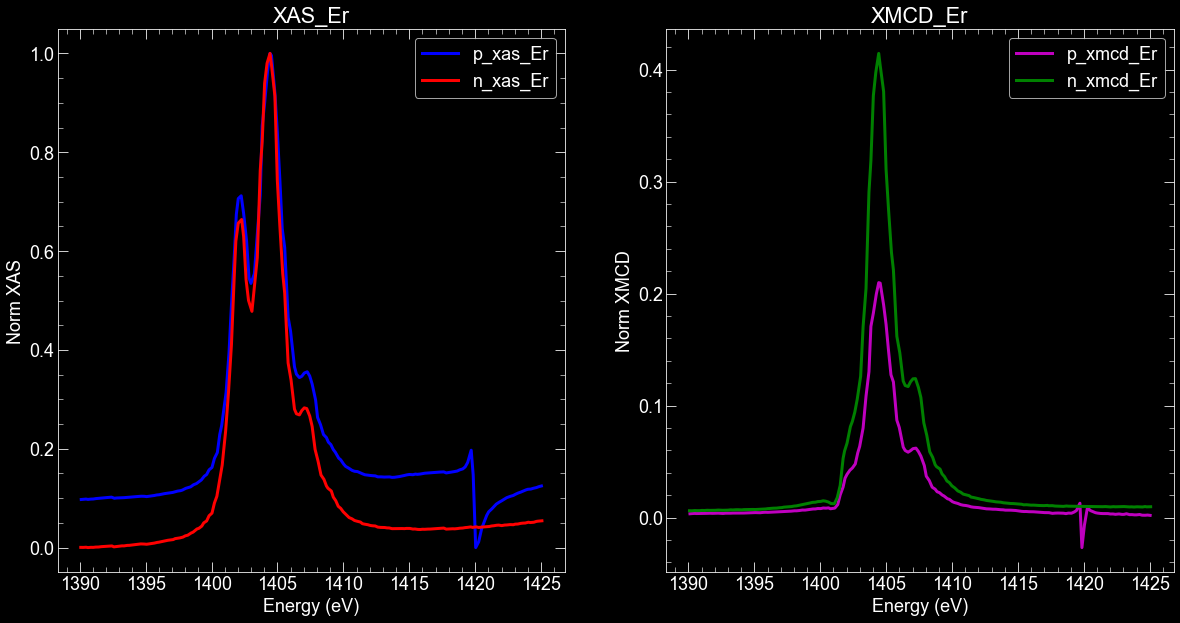

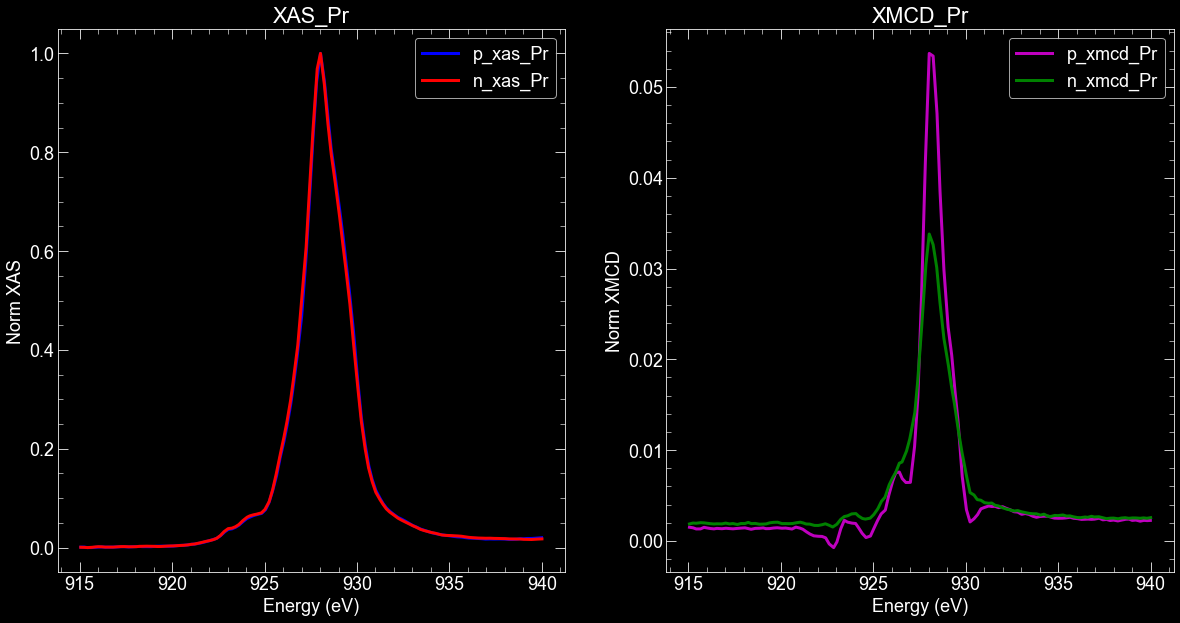

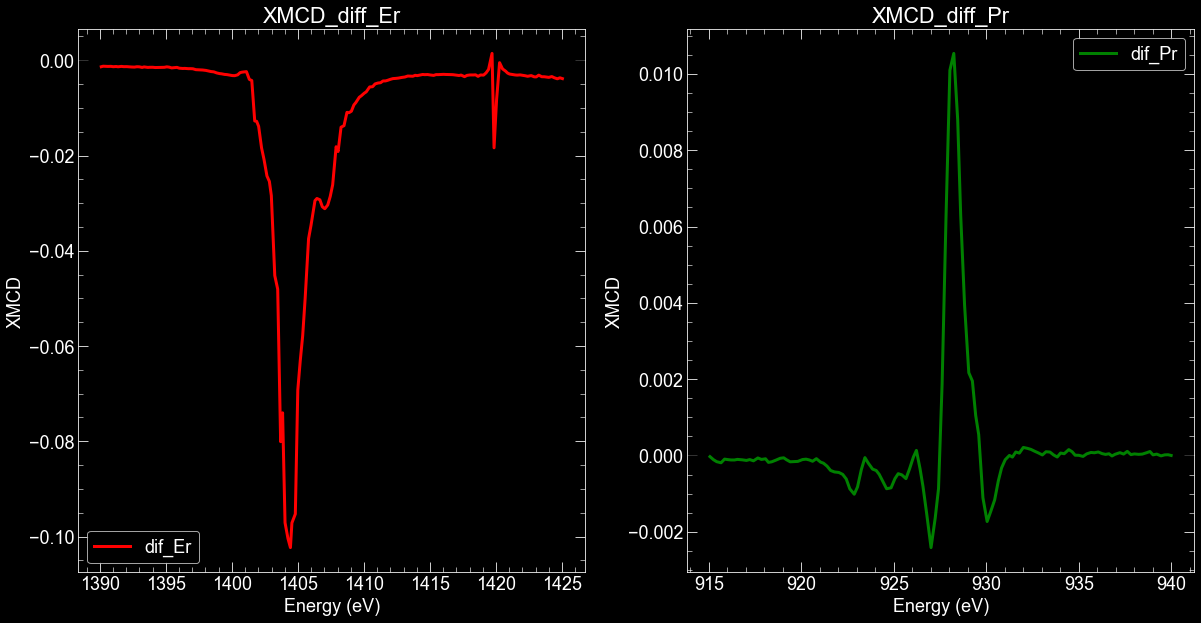

In [55]:
#Binary alloys- 
#Er:+- 0.1 T=(382/385) and +-2T=(384/386) Pr: +-0.1 T=(394/400) and +-2T=(399/401)
#ErPr_XMCD_diff( Erscan_pT=384, Erscan_nT=386, Prscan_pT=399, Prscan_nT=401) #+-2T
#ErPr_XMCD_diff( Erscan_pT=382, Erscan_nT=385, Prscan_pT=394, Prscan_nT=400)  #+-0.1T

#ErPr(100) 
#Er:+-5T=114/120, +-1T=116/122,  +-0.5T=118/124   Pr:+-5T=115/121, +-1T=117/123,  +-0.5T=119/125) 
#ErPr_XMCD_diff( Erscan_pT=114, Erscan_nT=120, Prscan_pT=115, Prscan_nT=121) #5 T
ErPr_XMCD_diff( Erscan_pT=116, Erscan_nT=122, Prscan_pT=117, Prscan_nT=123) #+-1 T
#ErPr_XMCD_diff( Erscan_pT=118, Erscan_nT=124, Prscan_pT=119, Prscan_nT=125) #+-0.5 T

#ErPr(110) 
#Er:+-4T=173/247, +-2T=165/241,  +-1T=161/239   Pr:+-4T=174/248, +-2T=166/242,  +-1T=162/240) 
#ErPr_XMCD_diff( Erscan_pT=173, Erscan_nT=247, Prscan_pT=174, Prscan_nT=248) #4 T
#ErPr_XMCD_diff( Erscan_pT=173, Erscan_nT=247, Prscan_pT=174, Prscan_nT=248) #3 T
#ErPr_XMCD_diff( Erscan_pT=169, Erscan_nT=245, Prscan_pT=170, Prscan_nT=246) #+-2 T
#ErPr_XMCD_diff( Erscan_pT=161, Erscan_nT=239, Prscan_pT=162, Prscan_nT=240) #+-1 T


#ErPr(111) +-0.1 T
#ErPr_XMCD_diff( Erscan_pT=351, Erscan_nT=360, Prscan_pT=352, Prscan_nT=361)

In [49]:
def ErPr_XMCD( Erscan, Prscan ):
    energy_Er, ref_sum_Er, xmcd_ref_Er, tey_sum_Er, xmcd_tey_Er, tfy_sum_Er, xmcd_tfy_Er,std_Er = XMCD(sf,Erscan)
    energy_Pr, ref_sum_Pr, xmcd_ref_Pr, tey_sum_Pr, xmcd_tey_Pr, tfy_sum_Pr, xmcd_tfy_Pr,std_Pr = XMCD(sf,Prscan)

    #reverse order of points
    energy_Er = energy_Er[::-1]
    tey_sum_Er = tey_sum_Er[::-1]
    xmcd_tey_Er = xmcd_tey_Er[::-1]
    ref_sum_Er = ref_sum_Er[::-1]
    xmcd_ref_Er = xmcd_ref_Er[::-1]
    std_Er = std_Er[::-1]

    energy_Pr = energy_Pr[::-1]
    tey_sum_Pr = tey_sum_Pr[::-1]
    xmcd_tey_Pr = xmcd_tey_Pr[::-1]
    ref_sum_Pr = ref_sum_Pr[::-1]
    xmcd_ref_Pr = xmcd_ref_Pr[::-1]
    std_Pr = std_Pr[::-1]
    
    sctey_Er, scxmcd_tey_Er = norm_xmcd(tey_sum_Er, xmcd_tey_Er);
    sctey_Pr, scxmcd_tey_Pr = norm_xmcd(tey_sum_Pr, xmcd_tey_Pr);
    
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))    

    ax1.set_ylabel('XAS')
    ax1.set_xlabel('Energy (eV)')
    ax1.plot(energy_Er,sctey_Er,'b',linewidth=3,label='Er')
    ax1.legend()
    ax1.set_title('XAS_Er')

    ax2.set_ylabel('XMCD')
    ax2.set_xlabel('Energy (eV)')
    ax2.plot(energy_Er,scxmcd_tey_Er,'m',linewidth=3,label='Er')
    ax2.legend()
    ax2.set_title('XMCD_Er')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_ylabel('XAS')
    ax1.set_xlabel('Energy (eV)')
    ax1.plot(energy_Pr,sctey_Pr,'b',linewidth=3,label='Pr')
    ax1.legend()
    ax1.set_title('XAS_Pr')

    ax2.set_ylabel('XMCD')
    ax1.set_xlabel('Energy (eV)')
    ax2.plot(energy_Pr,scxmcd_tey_Pr,'m',linewidth=3,label='Pr')
    ax2.legend()
    ax2.set_title('XMCD_Pr')
    plt.show()

Normalization:  1.238972942563
Normalization:  1.2209742384


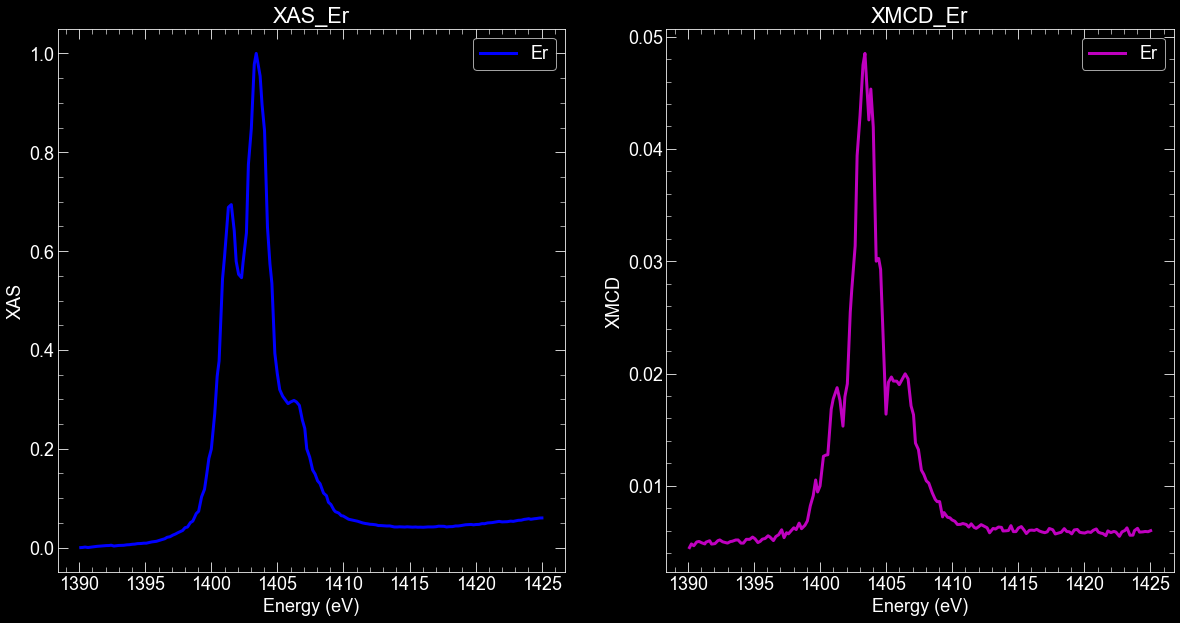

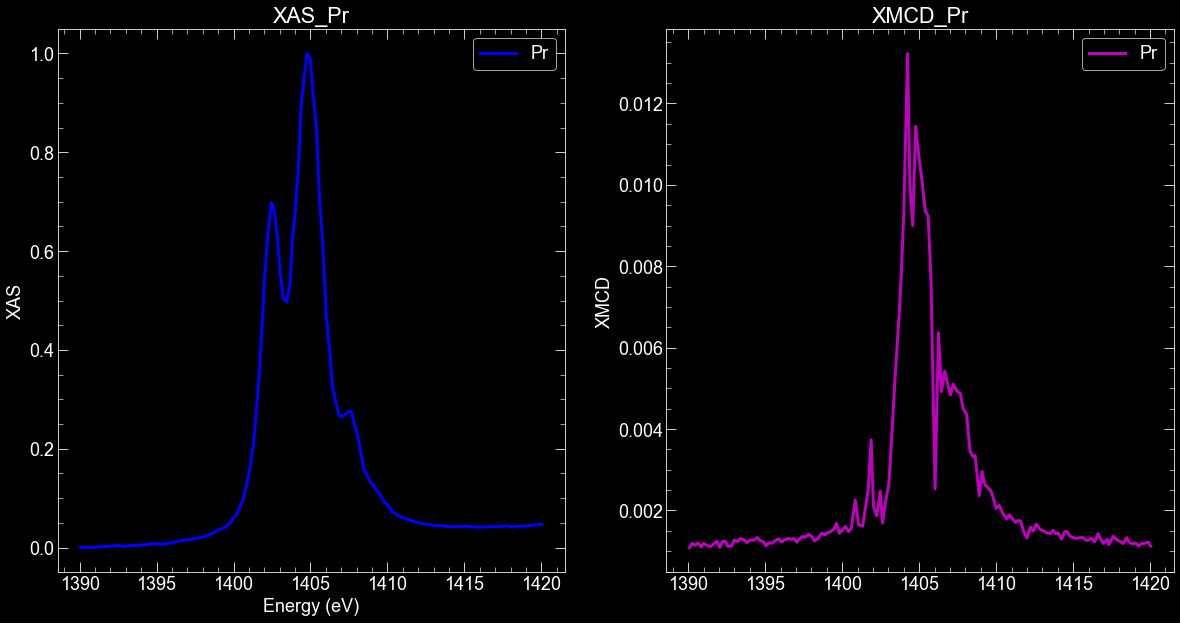

In [50]:
#

ErPr_XMCD( 41, 373 )